In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import torch
import numpy as np
from collections import Counter
from torch_geometric.loader import DataLoader
import torch.nn as nn
from torch.optim import Adam
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split

from pathlib import Path
import os

# custom modules
from models import Generator, Discriminator
from custom_dataset import CustomSequenceDataset
from preprocess_data import read_adfa_data, sequence_to_graph, fetch_graph_data
from utils import get_device, plot_loss_curve, evaluate_gcn_model
from classifiers import GCNModel
from train import train_gan_model
from train import train_gcn_model

# read, preprocess, and fetch the ADFA datasets


In [2]:
data_folder = "ADFA"  # make sure "ADFA" folder in the parent directory of this project's folder [ie., your codes]
current_directory = Path(os.getcwd())
parent_path = current_directory.parent.absolute()
# print(current_directory.parent.absolute())

full_data_folder_path = os.path.join(parent_path, data_folder)

In [3]:
adfa_sub_folders = [
    "Training_Data_Master",
    "Validation_Data_Master",
    "Attack_Data_Master",
]

benign_training_data_path = os.path.join(full_data_folder_path, adfa_sub_folders[0])
benign_validation_data_path = os.path.join(full_data_folder_path, adfa_sub_folders[1])

attack_data_path = os.path.join(full_data_folder_path, adfa_sub_folders[2])


# read the sub folders
benign_train_sequences, benign_train_labels = read_adfa_data(benign_training_data_path)

benign_val_sequences, benign_val_labels = read_adfa_data(benign_validation_data_path)

attack_sequences, attack_labels = read_adfa_data(attack_data_path)


data = benign_train_sequences + benign_val_sequences + attack_sequences
labels = benign_train_labels + benign_val_labels + attack_labels

# perform  70 % training and 30% testing set split

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.3, random_state=42, shuffle=True, stratify=labels
)

len(train_data), len(train_labels), len(test_data), len(test_labels)

Read 833 sequences from Training_Data_Master
Read 4372 sequences from Validation_Data_Master
Read 746 sequences from Attack_Data_Master


(4165, 4165, 1786, 1786)

In [4]:
len(attack_sequences)

746

In [5]:
# Data is imbalanced: 1666 samples of benign & 1051 samples of attack (malignant) will be used for training the GCN model
Counter(train_labels)

Counter({0: 3643, 1: 522})

In [6]:
Counter(test_labels)

Counter({0: 1562, 1: 224})

In [7]:
# Create a custom dataset
batch_size = 64
# convert train_data sequences and val_data sequences into graphs

train_graph_dataset = fetch_graph_data(train_data, train_labels)
val_graph_dataset = fetch_graph_data(test_data, test_labels)


# Create a data loader
graph_train_loader = DataLoader(
    train_graph_dataset, batch_size=batch_size, shuffle=True
)
graph_val_loader = DataLoader(val_graph_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# you can see the graph data: it has edge_index, weight, num_nodes, y (label of the graph, i.e., malign or benign), and x (node features). Here, x is a list of integers representing the node features. They need to be converted to a one-hot vector of size vocab_size or vector of embedded representation.
train_graph_dataset[0]

Data(edge_index=[2, 63], weight=[63], num_nodes=17, x=[1], y=0)

In [9]:
# device = get_device()
vocab_size = 342
hidden_dim = 128  # also the number of hidden nodes in the GCN. Can be set to 128, 256 or 512. If you have more GPU, you can increase it. However, you may face overfitting. Increase dropout if you face overfitting. Like dropout = 0.6, 0.7, 0.8
num_classes = 2
dropout = 0.4
output_dim = num_classes
# number of GCN layers, depending on your GPU, set it to any integer from 2 to 5.
num_layers = 3
EPOCHS_GCN = 35


device = torch.device("cpu")


gcn_model = GCNModel(
    in_channels=vocab_size,
    hidden_channels=hidden_dim,
    out_channels=num_classes,
    num_layers=num_layers,
    dropout=dropout,
).to(device)

train_losses, train_f1_scores = train_gcn_model(
    gcn_model,
    graph_train_loader,
    vocab_size=vocab_size,
    epochs=EPOCHS_GCN,
    device=device,
)

100%|██████████| 66/66 [00:01<00:00, 42.13it/s]


Epoch 1 / 35, Loss: 0.4684, F1 Score: 0.0045


100%|██████████| 66/66 [00:01<00:00, 35.92it/s]


Epoch 2 / 35, Loss: 0.4136, F1 Score: 0.2949


100%|██████████| 66/66 [00:01<00:00, 45.38it/s]


Epoch 3 / 35, Loss: 0.4024, F1 Score: 0.5338


100%|██████████| 66/66 [00:01<00:00, 51.77it/s]


Epoch 4 / 35, Loss: 0.3938, F1 Score: 0.5475


100%|██████████| 66/66 [00:01<00:00, 50.27it/s]


Epoch 5 / 35, Loss: 0.3930, F1 Score: 0.5562


100%|██████████| 66/66 [00:01<00:00, 50.22it/s]


Epoch 6 / 35, Loss: 0.3919, F1 Score: 0.5873


100%|██████████| 66/66 [00:01<00:00, 49.85it/s]


Epoch 7 / 35, Loss: 0.3935, F1 Score: 0.5927


100%|██████████| 66/66 [00:01<00:00, 52.11it/s]


Epoch 8 / 35, Loss: 0.3912, F1 Score: 0.5622


100%|██████████| 66/66 [00:01<00:00, 50.86it/s]


Epoch 9 / 35, Loss: 0.3905, F1 Score: 0.5956


100%|██████████| 66/66 [00:01<00:00, 52.20it/s]


Epoch 10 / 35, Loss: 0.3906, F1 Score: 0.5747


100%|██████████| 66/66 [00:01<00:00, 50.16it/s]


Epoch 11 / 35, Loss: 0.3895, F1 Score: 0.5993


100%|██████████| 66/66 [00:01<00:00, 51.06it/s]


Epoch 12 / 35, Loss: 0.3898, F1 Score: 0.5994


100%|██████████| 66/66 [00:01<00:00, 51.58it/s]


Epoch 13 / 35, Loss: 0.3893, F1 Score: 0.5934


100%|██████████| 66/66 [00:01<00:00, 50.57it/s]


Epoch 14 / 35, Loss: 0.3974, F1 Score: 0.5838


100%|██████████| 66/66 [00:01<00:00, 50.33it/s]


Epoch 15 / 35, Loss: 0.3902, F1 Score: 0.5898


100%|██████████| 66/66 [00:01<00:00, 51.05it/s]


Epoch 16 / 35, Loss: 0.3884, F1 Score: 0.5862


100%|██████████| 66/66 [00:01<00:00, 51.77it/s]


Epoch 17 / 35, Loss: 0.3883, F1 Score: 0.6090


100%|██████████| 66/66 [00:01<00:00, 50.03it/s]


Epoch 18 / 35, Loss: 0.3877, F1 Score: 0.6192


100%|██████████| 66/66 [00:01<00:00, 50.62it/s]


Epoch 19 / 35, Loss: 0.3883, F1 Score: 0.6050


100%|██████████| 66/66 [00:01<00:00, 50.47it/s]


Epoch 20 / 35, Loss: 0.3877, F1 Score: 0.6194


100%|██████████| 66/66 [00:01<00:00, 49.32it/s]


Epoch 21 / 35, Loss: 0.3850, F1 Score: 0.6314


100%|██████████| 66/66 [00:01<00:00, 42.06it/s]


Epoch 22 / 35, Loss: 0.3851, F1 Score: 0.6061


100%|██████████| 66/66 [00:01<00:00, 43.31it/s]


Epoch 23 / 35, Loss: 0.3839, F1 Score: 0.6272


100%|██████████| 66/66 [00:01<00:00, 36.87it/s]


Epoch 24 / 35, Loss: 0.3856, F1 Score: 0.6584


100%|██████████| 66/66 [00:01<00:00, 46.74it/s]


Epoch 25 / 35, Loss: 0.3797, F1 Score: 0.6511


100%|██████████| 66/66 [00:01<00:00, 48.88it/s]


Epoch 26 / 35, Loss: 0.3736, F1 Score: 0.7214


100%|██████████| 66/66 [00:01<00:00, 44.21it/s]


Epoch 27 / 35, Loss: 0.3733, F1 Score: 0.7112


100%|██████████| 66/66 [00:01<00:00, 49.13it/s]


Epoch 28 / 35, Loss: 0.3697, F1 Score: 0.7312


100%|██████████| 66/66 [00:01<00:00, 48.56it/s]


Epoch 29 / 35, Loss: 0.3664, F1 Score: 0.7362


100%|██████████| 66/66 [00:01<00:00, 49.29it/s]


Epoch 30 / 35, Loss: 0.3641, F1 Score: 0.7501


100%|██████████| 66/66 [00:01<00:00, 48.40it/s]


Epoch 31 / 35, Loss: 0.3633, F1 Score: 0.7543


100%|██████████| 66/66 [00:01<00:00, 47.59it/s]


Epoch 32 / 35, Loss: 0.3625, F1 Score: 0.7547


100%|██████████| 66/66 [00:01<00:00, 46.82it/s]


Epoch 33 / 35, Loss: 0.3611, F1 Score: 0.7588


100%|██████████| 66/66 [00:01<00:00, 49.67it/s]


Epoch 34 / 35, Loss: 0.3615, F1 Score: 0.7589


100%|██████████| 66/66 [00:01<00:00, 49.89it/s]

Epoch 35 / 35, Loss: 0.3606, F1 Score: 0.7695


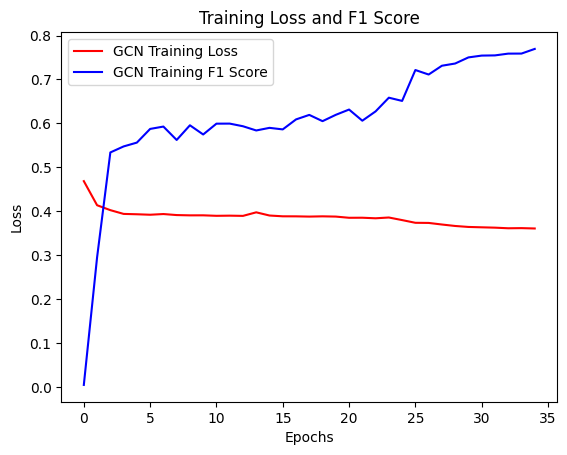

In [10]:
x = np.arange(EPOCHS_GCN, dtype=int)
plt.plot(x, train_losses, color="red", label="GCN Training Loss")
plt.plot(x, train_f1_scores, color="blue", label="GCN Training F1 Score")
plt.title("Training Loss and F1 Score")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [11]:
evaluate_gcn_model(gcn_model, graph_val_loader, vocab_size=vocab_size, device=device)

GCN performance:
Accuracy: 0.9591
Precision: 0.9276
Recall: 0.8791
F1 score: 0.9013
MCC: 0.8052


In [12]:
# PREPARE DATASET FOR GAN MODEL: pad the sequences to make them of same length, then trim them to a fixed sequence length to avoid too much padding.
# convert train_data sequences and val_data sequences into graphs
SEQUENCE_LENGTH = 100
train_data_padded = pad_sequence(
    [torch.tensor(sequence, dtype=torch.long) for sequence in train_data],
    batch_first=True,
)
val_data_padded = pad_sequence(
    [torch.tensor(sequence, dtype=torch.long) for sequence in test_data],
    batch_first=True,
)

train_data_padded.shape, val_data_padded.shape

(torch.Size([4165, 4094]), torch.Size([1786, 4494]))

In [13]:
train_data_padded[:, SEQUENCE_LENGTH].shape, val_data_padded[:SEQUENCE_LENGTH].shape

# our dataset will be of shape (n_samples, SEQUENCE_LENGTH).
train_dataset = CustomSequenceDataset(
    train_data_padded[:, :SEQUENCE_LENGTH], train_labels
)
val_dataset = CustomSequenceDataset(val_data_padded[:, :SEQUENCE_LENGTH], test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [14]:
# hyperparameters of the generator and discriminator of the GAN model
latent_dim = 100
hidden_dim = 128
vocab_size = 342  # we have 342 unique system calls in the ADFA dataset
seq_len = SEQUENCE_LENGTH  # sequence length of the ADFA dataset with less than 120, will be padded. If sequence is longer than 120, it will be truncated.
output_dim = vocab_size
embed_dim = 10
dropout = 0.5
batch_size = 32
n_samples = 1000
num_classes = 2
lr = 1e-4  # 2e-6
epochs = 50
# criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()
device = get_device()
temperature = 0.2  # 0.1

gen = Generator(
    latent_dim,
    seq_len,
    hidden_dim,
    output_dim,
    embed_dim,
    dropout,
    conditional_info=True,
    num_classes=num_classes,
).to(device)
# gen = Gen(latent_dim, hidden_dim, seq_len, output_dim, embed_dim, dropout).to(device)

disc = Discriminator(
    vocab_size,
    seq_len,
    hidden_dim,
    embed_dim,
    dropout,
    conditional_info=True,
    num_classes=num_classes,
).to(device)

gen_optimizer = Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))

disc_optimizer = Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))

In [15]:
device = get_device()

In [16]:
# input_data = torch.randint(0, vocab_size, (n_samples, seq_len))
# input_labels = torch.randint(0, num_classes, (n_samples,))
# train_dataset = CustomSequenceDataset(input_data, input_labels)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [17]:
# note that the temperature is set to any value between 0 and 1.
g_losses, d_losses = train_gan_model(
    gen,
    disc,
    gen_optimizer,
    disc_optimizer,
    train_loader,
    epochs,
    vocab_size,
    device=device,
    tau=temperature,
)

Epoch 1 / 50


100%|██████████| 66/66 [00:08<00:00,  7.44it/s]


D Loss: 1.3897, G Loss: -0.7246
Epoch 2 / 50


100%|██████████| 66/66 [00:04<00:00, 15.08it/s]


D Loss: 1.3813, G Loss: -0.7197
Epoch 3 / 50


100%|██████████| 66/66 [00:04<00:00, 15.39it/s]


D Loss: 1.3864, G Loss: -0.7069
Epoch 4 / 50


100%|██████████| 66/66 [00:04<00:00, 13.75it/s]


D Loss: 1.3885, G Loss: -0.7066
Epoch 5 / 50


100%|██████████| 66/66 [00:03<00:00, 16.67it/s]


D Loss: 1.3919, G Loss: -0.6976
Epoch 6 / 50


100%|██████████| 66/66 [00:04<00:00, 15.22it/s]


D Loss: 1.3912, G Loss: -0.6887
Epoch 7 / 50


100%|██████████| 66/66 [00:04<00:00, 15.78it/s]


D Loss: 1.3839, G Loss: -0.6988
Epoch 8 / 50


100%|██████████| 66/66 [00:04<00:00, 15.20it/s]


D Loss: 1.3852, G Loss: -0.6961
Epoch 9 / 50


100%|██████████| 66/66 [00:04<00:00, 15.98it/s]


D Loss: 1.3758, G Loss: -0.6991
Epoch 10 / 50


100%|██████████| 66/66 [00:03<00:00, 16.54it/s]


D Loss: 1.3871, G Loss: -0.6965
Epoch 11 / 50


100%|██████████| 66/66 [00:04<00:00, 14.61it/s]


D Loss: 1.3850, G Loss: -0.7025
Epoch 12 / 50


100%|██████████| 66/66 [00:05<00:00, 12.79it/s]


D Loss: 1.3910, G Loss: -0.6922
Epoch 13 / 50


100%|██████████| 66/66 [00:04<00:00, 15.04it/s]


D Loss: 1.3853, G Loss: -0.6977
Epoch 14 / 50


100%|██████████| 66/66 [00:04<00:00, 15.08it/s]


D Loss: 1.3947, G Loss: -0.6970
Epoch 15 / 50


100%|██████████| 66/66 [00:04<00:00, 14.05it/s]


D Loss: 1.3937, G Loss: -0.6873
Epoch 16 / 50


100%|██████████| 66/66 [00:05<00:00, 11.94it/s]


D Loss: 1.3782, G Loss: -0.6962
Epoch 17 / 50


100%|██████████| 66/66 [00:04<00:00, 15.01it/s]


D Loss: 1.3861, G Loss: -0.6935
Epoch 18 / 50


100%|██████████| 66/66 [00:04<00:00, 14.07it/s]


D Loss: 1.3883, G Loss: -0.6969
Epoch 19 / 50


100%|██████████| 66/66 [00:04<00:00, 13.88it/s]


D Loss: 1.3933, G Loss: -0.6955
Epoch 20 / 50


100%|██████████| 66/66 [00:04<00:00, 15.53it/s]


D Loss: 1.3866, G Loss: -0.6930
Epoch 21 / 50


100%|██████████| 66/66 [00:04<00:00, 15.13it/s]


D Loss: 1.3977, G Loss: -0.6984
Epoch 22 / 50


100%|██████████| 66/66 [00:05<00:00, 12.27it/s]


D Loss: 1.3872, G Loss: -0.6966
Epoch 23 / 50


100%|██████████| 66/66 [00:05<00:00, 11.69it/s]


D Loss: 1.3774, G Loss: -0.6954
Epoch 24 / 50


100%|██████████| 66/66 [00:05<00:00, 12.74it/s]


D Loss: 1.3744, G Loss: -0.7002
Epoch 25 / 50


100%|██████████| 66/66 [00:05<00:00, 13.11it/s]


D Loss: 1.3899, G Loss: -0.6912
Epoch 26 / 50


100%|██████████| 66/66 [00:05<00:00, 12.82it/s]


D Loss: 1.3849, G Loss: -0.6905
Epoch 27 / 50


100%|██████████| 66/66 [00:04<00:00, 13.41it/s]


D Loss: 1.3881, G Loss: -0.6893
Epoch 28 / 50


100%|██████████| 66/66 [00:04<00:00, 13.72it/s]


D Loss: 1.3907, G Loss: -0.6961
Epoch 29 / 50


100%|██████████| 66/66 [00:05<00:00, 13.19it/s]


D Loss: 1.3850, G Loss: -0.6941
Epoch 30 / 50


100%|██████████| 66/66 [00:04<00:00, 13.54it/s]


D Loss: 1.3881, G Loss: -0.6936
Epoch 31 / 50


100%|██████████| 66/66 [00:05<00:00, 12.91it/s]


D Loss: 1.3842, G Loss: -0.6961
Epoch 32 / 50


100%|██████████| 66/66 [00:04<00:00, 13.45it/s]


D Loss: 1.3962, G Loss: -0.6915
Epoch 33 / 50


100%|██████████| 66/66 [00:04<00:00, 13.36it/s]


D Loss: 1.3757, G Loss: -0.6995
Epoch 34 / 50


100%|██████████| 66/66 [00:04<00:00, 13.68it/s]


D Loss: 1.3943, G Loss: -0.6903
Epoch 35 / 50


100%|██████████| 66/66 [00:04<00:00, 13.95it/s]


D Loss: 1.3905, G Loss: -0.6958
Epoch 36 / 50


100%|██████████| 66/66 [00:05<00:00, 12.19it/s]


D Loss: 1.3840, G Loss: -0.6903
Epoch 37 / 50


100%|██████████| 66/66 [00:05<00:00, 12.55it/s]


D Loss: 1.3865, G Loss: -0.6959
Epoch 38 / 50


100%|██████████| 66/66 [00:05<00:00, 11.24it/s]


D Loss: 1.3784, G Loss: -0.6943
Epoch 39 / 50


100%|██████████| 66/66 [00:05<00:00, 13.06it/s]


D Loss: 1.3842, G Loss: -0.6923
Epoch 40 / 50


100%|██████████| 66/66 [00:05<00:00, 11.51it/s]


D Loss: 1.3957, G Loss: -0.6961
Epoch 41 / 50


100%|██████████| 66/66 [00:04<00:00, 13.64it/s]


D Loss: 1.3816, G Loss: -0.6926
Epoch 42 / 50


100%|██████████| 66/66 [00:04<00:00, 14.02it/s]


D Loss: 1.3875, G Loss: -0.6936
Epoch 43 / 50


100%|██████████| 66/66 [00:05<00:00, 12.87it/s]


D Loss: 1.3911, G Loss: -0.6897
Epoch 44 / 50


100%|██████████| 66/66 [00:04<00:00, 14.10it/s]


D Loss: 1.3980, G Loss: -0.6945
Epoch 45 / 50


100%|██████████| 66/66 [00:04<00:00, 14.18it/s]


D Loss: 1.3902, G Loss: -0.6853
Epoch 46 / 50


100%|██████████| 66/66 [00:04<00:00, 14.26it/s]


D Loss: 1.3926, G Loss: -0.6961
Epoch 47 / 50


100%|██████████| 66/66 [00:04<00:00, 14.93it/s]


D Loss: 1.3919, G Loss: -0.6963
Epoch 48 / 50


100%|██████████| 66/66 [00:04<00:00, 14.13it/s]


D Loss: 1.3926, G Loss: -0.6897
Epoch 49 / 50


100%|██████████| 66/66 [00:04<00:00, 14.19it/s]


D Loss: 1.3844, G Loss: -0.6938
Epoch 50 / 50


100%|██████████| 66/66 [00:04<00:00, 14.80it/s]

D Loss: 1.3859, G Loss: -0.6906


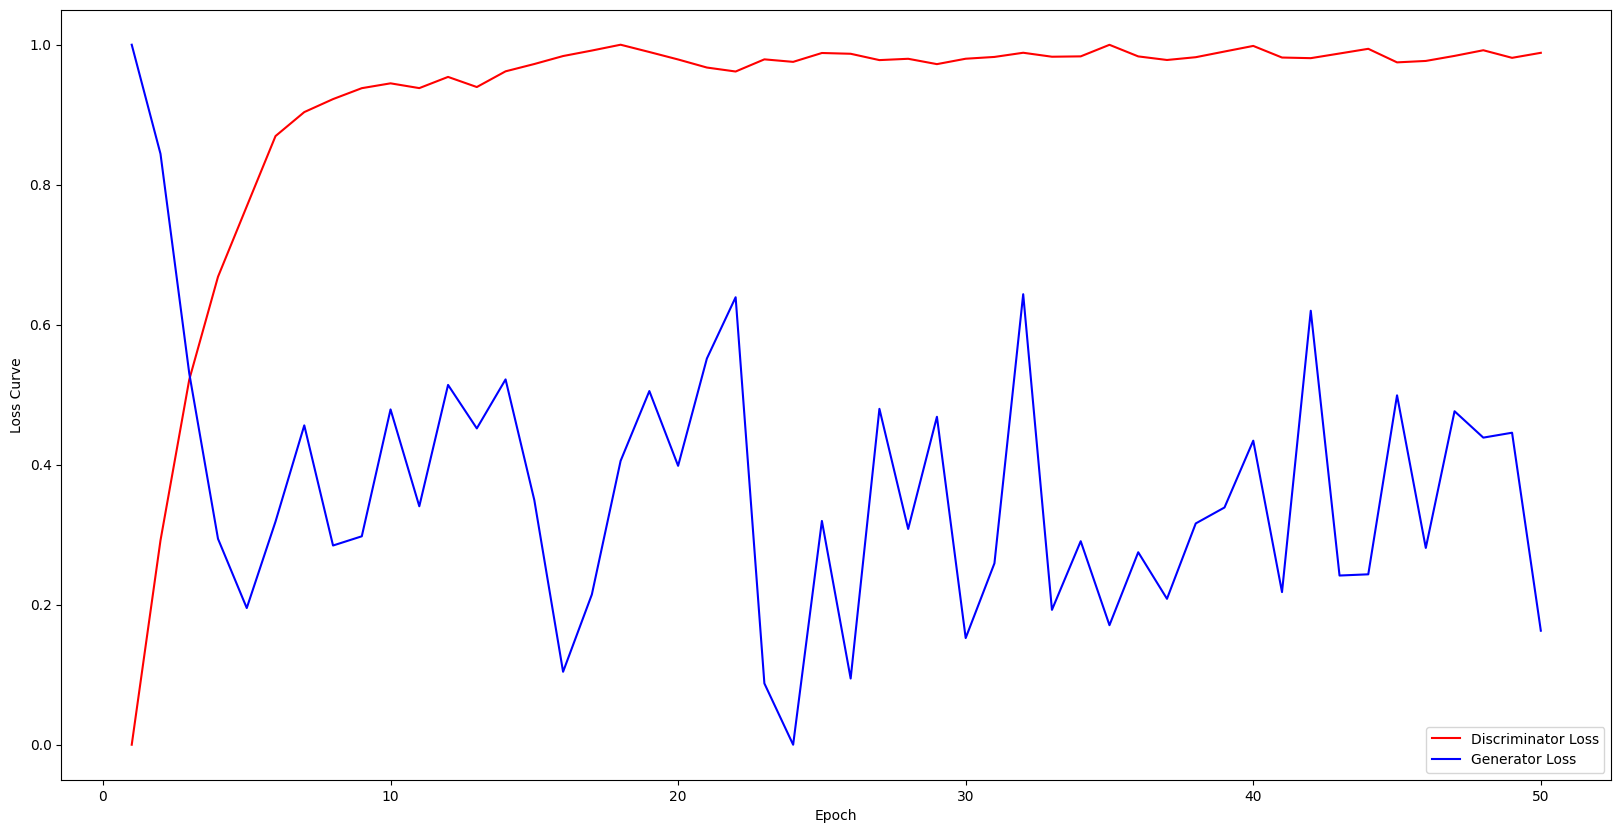

In [18]:
plot_loss_curve(g_losses, d_losses, epochs)

## generate fake samples


In [19]:
fake_labels = torch.randint(0, num_classes, (n_samples,), dtype=torch.long)
z = torch.randn((n_samples, latent_dim))

# print("random noise shape", z.shape)
# set generator to eval mode
gen.eval()

fake_data = gen(z.to(device), fake_labels.to(device)).detach().cpu()

# print the generated data: if the data contains nan values, it means that there is gradient explosion, or other issues. To avoid such problems, change the termperature value to be between 0.1 and 0.5. Also, trying changing the learning rate to be between 5e-6 and 1e-4. Of course, this is just a suggestion. You might experiment with other values if you want, and report your findings.
# print(fake_data[0])

In [20]:
# get the generated samples as tokens (this are a sequence tokens or words / characters, represented by integers .)
from pprint import pprint

fake_samples = torch.argmax(fake_data, dim=-1).cpu().numpy()

# now, let's see two generated sequences
pprint(fake_samples[:2])

array([[196, 286, 162, 256,  50, 329, 215,  64, 262, 136,  53, 313, 239,
        183,  40, 242, 116,  96, 206, 166, 209, 231, 211, 335, 225,  62,
        269, 230, 334, 333, 164, 123, 312, 225, 108, 286, 159,  63, 194,
        202,  47,  24, 276, 106,  63, 248,  80, 269, 143, 230, 107, 288,
        109, 281, 183, 276, 145,  26, 312,  77,  70, 320, 292, 262, 126,
         62,  12,  84, 176, 147,  40,  33, 327, 173, 255,  38, 211, 213,
        118, 293, 190,  23,  72, 205, 264, 202,  25, 202, 204, 210, 303,
        314,   9, 307, 337, 150,  80, 200, 298, 332],
       [307, 206, 232, 147, 292,  73, 154,  69, 123, 283,  78, 286, 301,
        291, 139, 172, 177,  67,  43, 331, 226, 101, 195, 143, 314,  74,
        229, 103, 290, 328,  95,  70, 106, 312, 114, 313,  12, 267, 252,
        339, 208,  53,   8, 201, 194, 306, 153, 141,  86,  22, 212, 325,
        282, 282, 111, 318,  16, 157, 232, 198, 271,  33, 216, 307, 189,
        320, 276, 257, 257, 201, 195, 103, 161, 181, 310, 191, 280, 33

# Now, we can generate from generated tokens (i.e., sequence)

` To do so, we can use the sequence_to_graph() function given in the preprocess_data.py`


In [21]:
# convert the generated samples into a networkx graph and also pytorch_geometric graph data object
networkx_graph, pytorch_geometric_data = sequence_to_graph(fake_samples[0])

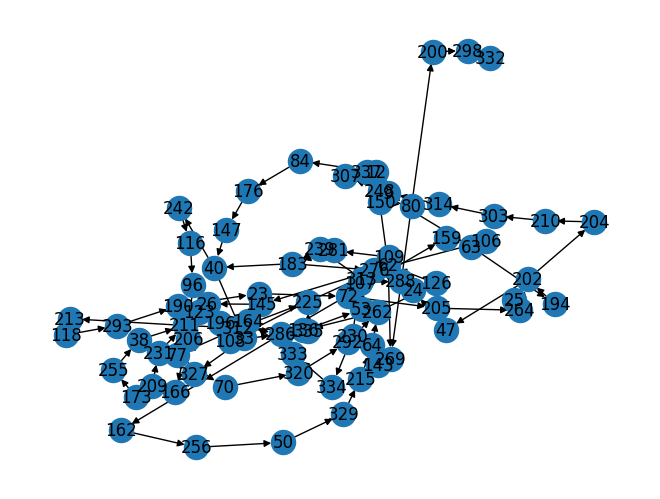

In [22]:
# you can see the networkx graph we generated
nx.draw(networkx_graph, with_labels=True)
plt.show()

# The Remaining Steps:

```
1 - generate many fake samples (sequences and their corresponding labels),

2 - add these fake sequences to train_data sequences, and add their fake_labels (benign or malign) to the trian_labels

3 - train a new GCNModel and compare performance before and after adding fake samples.


```
